In [1]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, VarianceThreshold

import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# I. Подготовка данных.

In [2]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [5]:
df.set_index('ID', inplace=True)

In [6]:
df.select_dtypes(exclude='object').head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# II. Filter methods

## 1. Mutual information

In [8]:
mutual_information = mutual_info_classif(X, y)

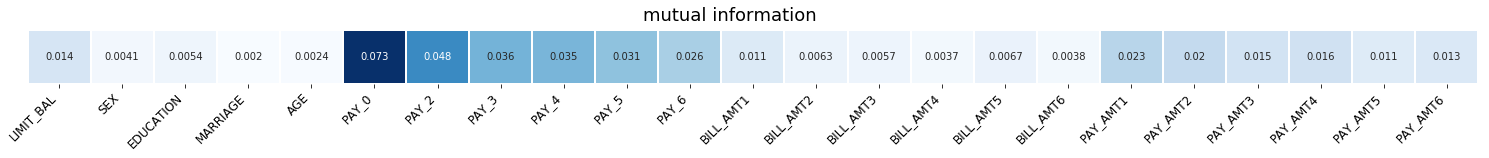

In [9]:
plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information.reshape(1, -1), cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns, rotation=45, ha='right', fontsize=12)
plt.suptitle("mutual information", fontsize=18, y=1.2)
plt.show()

In [10]:
mutual_information_threshold = 0.01
X_new = X[X.columns[mutual_information > mutual_information_threshold]]

In [11]:
X_new.shape

(30000, 14)

In [12]:
def gini(target, feature):
    return 2*roc_auc_score(target, feature) - 1

# III. Modeling

In [13]:
X_new.shape

(30000, 14)

In [15]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'n_jobs': -1,
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_exact'
}

In [16]:
model = xgb.XGBClassifier(**xgb_params)

In [17]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_exact')

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.33, random_state=42, stratify=y)

In [20]:
%%time
model.fit(X_new, y, early_stopping_rounds=10, eval_metric=['logloss', 'auc'], eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-logloss:0.688686	validation_0-auc:0.734957	validation_1-logloss:0.688717	validation_1-auc:0.732052
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.684312	validation_0-auc:0.734957	validation_1-logloss:0.684375	validation_1-auc:0.732052
[2]	validation_0-logloss:0.680025	validation_0-auc:0.73505	validation_1-logloss:0.68012	validation_1-auc:0.732135
[3]	validation_0-logloss:0.675822	validation_0-auc:0.735079	validation_1-logloss:0.675947	validation_1-auc:0.732241
[4]	validation_0-logloss:0.671701	validation_0-auc:0.735079	validation_1-logloss:0.671856	validation_1-auc:0.732241
[5]	validation_0-logloss:0.667657	validation_0-auc:0.749493	validation_1-logloss:0.66785	validation_1-auc:0.744716
[6]	validation_0-logloss:0.663693	validation_0-auc:0.749493	validation_1-logloss:0.663917	validation_1-auc:0.744716
[7]	validation_0-logloss:0.659803	

[70]	validation_0-logloss:0.513912	validation_0-auc:0.76818	validation_1-logloss:0.515979	validation_1-auc:0.76258
[71]	validation_0-logloss:0.512615	validation_0-auc:0.768161	validation_1-logloss:0.514711	validation_1-auc:0.762542
[72]	validation_0-logloss:0.511341	validation_0-auc:0.768259	validation_1-logloss:0.513456	validation_1-auc:0.762594
[73]	validation_0-logloss:0.510076	validation_0-auc:0.768555	validation_1-logloss:0.512214	validation_1-auc:0.762971
[74]	validation_0-logloss:0.508843	validation_0-auc:0.768537	validation_1-logloss:0.511004	validation_1-auc:0.762889
[75]	validation_0-logloss:0.507624	validation_0-auc:0.768624	validation_1-logloss:0.509821	validation_1-auc:0.762865
[76]	validation_0-logloss:0.506422	validation_0-auc:0.768826	validation_1-logloss:0.508633	validation_1-auc:0.763046
[77]	validation_0-logloss:0.505247	validation_0-auc:0.768827	validation_1-logloss:0.507482	validation_1-auc:0.763046
[78]	validation_0-logloss:0.504081	validation_0-auc:0.769038	valid

[140]	validation_0-logloss:0.458492	validation_0-auc:0.773973	validation_1-logloss:0.461869	validation_1-auc:0.768219
[141]	validation_0-logloss:0.458046	validation_0-auc:0.77408	validation_1-logloss:0.461432	validation_1-auc:0.768334
[142]	validation_0-logloss:0.457613	validation_0-auc:0.774119	validation_1-logloss:0.461009	validation_1-auc:0.768379
[143]	validation_0-logloss:0.4572	validation_0-auc:0.774089	validation_1-logloss:0.460605	validation_1-auc:0.768393
[144]	validation_0-logloss:0.456773	validation_0-auc:0.774311	validation_1-logloss:0.460189	validation_1-auc:0.768673
[145]	validation_0-logloss:0.456362	validation_0-auc:0.774356	validation_1-logloss:0.459786	validation_1-auc:0.768784
[146]	validation_0-logloss:0.455955	validation_0-auc:0.774415	validation_1-logloss:0.459388	validation_1-auc:0.768814
[147]	validation_0-logloss:0.455562	validation_0-auc:0.774419	validation_1-logloss:0.459017	validation_1-auc:0.768803
[148]	validation_0-logloss:0.455168	validation_0-auc:0.7745

[210]	validation_0-logloss:0.439152	validation_0-auc:0.778182	validation_1-logloss:0.443213	validation_1-auc:0.772654
[211]	validation_0-logloss:0.438984	validation_0-auc:0.778249	validation_1-logloss:0.443052	validation_1-auc:0.772691
[212]	validation_0-logloss:0.438822	validation_0-auc:0.778279	validation_1-logloss:0.442903	validation_1-auc:0.772591
[213]	validation_0-logloss:0.438669	validation_0-auc:0.778344	validation_1-logloss:0.442749	validation_1-auc:0.772683
[214]	validation_0-logloss:0.438504	validation_0-auc:0.778386	validation_1-logloss:0.442594	validation_1-auc:0.772799
[215]	validation_0-logloss:0.438344	validation_0-auc:0.77848	validation_1-logloss:0.442441	validation_1-auc:0.772818
[216]	validation_0-logloss:0.438191	validation_0-auc:0.778534	validation_1-logloss:0.442302	validation_1-auc:0.772795
[217]	validation_0-logloss:0.438035	validation_0-auc:0.778615	validation_1-logloss:0.442156	validation_1-auc:0.772831
[218]	validation_0-logloss:0.43788	validation_0-auc:0.778

[280]	validation_0-logloss:0.431366	validation_0-auc:0.781798	validation_1-logloss:0.435924	validation_1-auc:0.775543
[281]	validation_0-logloss:0.431298	validation_0-auc:0.781903	validation_1-logloss:0.43586	validation_1-auc:0.775718
[282]	validation_0-logloss:0.431228	validation_0-auc:0.781938	validation_1-logloss:0.435794	validation_1-auc:0.775729
[283]	validation_0-logloss:0.431161	validation_0-auc:0.781947	validation_1-logloss:0.435734	validation_1-auc:0.775711
[284]	validation_0-logloss:0.431093	validation_0-auc:0.781962	validation_1-logloss:0.435669	validation_1-auc:0.775715
[285]	validation_0-logloss:0.431022	validation_0-auc:0.781997	validation_1-logloss:0.435607	validation_1-auc:0.775718
[286]	validation_0-logloss:0.430956	validation_0-auc:0.782075	validation_1-logloss:0.435546	validation_1-auc:0.775836
[287]	validation_0-logloss:0.430888	validation_0-auc:0.782108	validation_1-logloss:0.435461	validation_1-auc:0.775915
[288]	validation_0-logloss:0.43082	validation_0-auc:0.782

[350]	validation_0-logloss:0.427664	validation_0-auc:0.784869	validation_1-logloss:0.43217	validation_1-auc:0.77931
[351]	validation_0-logloss:0.42763	validation_0-auc:0.78493	validation_1-logloss:0.432138	validation_1-auc:0.779382
[352]	validation_0-logloss:0.427584	validation_0-auc:0.78501	validation_1-logloss:0.432084	validation_1-auc:0.779454
[353]	validation_0-logloss:0.427542	validation_0-auc:0.785048	validation_1-logloss:0.432035	validation_1-auc:0.779528
[354]	validation_0-logloss:0.427502	validation_0-auc:0.785113	validation_1-logloss:0.431985	validation_1-auc:0.779628
[355]	validation_0-logloss:0.42746	validation_0-auc:0.785191	validation_1-logloss:0.431928	validation_1-auc:0.779771
[356]	validation_0-logloss:0.42742	validation_0-auc:0.785244	validation_1-logloss:0.431878	validation_1-auc:0.779849
[357]	validation_0-logloss:0.427376	validation_0-auc:0.78529	validation_1-logloss:0.431826	validation_1-auc:0.779961
[358]	validation_0-logloss:0.42734	validation_0-auc:0.785303	val

[420]	validation_0-logloss:0.425418	validation_0-auc:0.787231	validation_1-logloss:0.429562	validation_1-auc:0.782865
[421]	validation_0-logloss:0.4254	validation_0-auc:0.787255	validation_1-logloss:0.429532	validation_1-auc:0.782922
[422]	validation_0-logloss:0.425368	validation_0-auc:0.78729	validation_1-logloss:0.429491	validation_1-auc:0.783004
[423]	validation_0-logloss:0.425343	validation_0-auc:0.787303	validation_1-logloss:0.429471	validation_1-auc:0.783004
[424]	validation_0-logloss:0.425323	validation_0-auc:0.787324	validation_1-logloss:0.429444	validation_1-auc:0.78308
[425]	validation_0-logloss:0.425299	validation_0-auc:0.787337	validation_1-logloss:0.429424	validation_1-auc:0.783073
[426]	validation_0-logloss:0.425282	validation_0-auc:0.787363	validation_1-logloss:0.429397	validation_1-auc:0.78312
[427]	validation_0-logloss:0.425256	validation_0-auc:0.787394	validation_1-logloss:0.429363	validation_1-auc:0.783156
[428]	validation_0-logloss:0.42523	validation_0-auc:0.787393	

[490]	validation_0-logloss:0.423863	validation_0-auc:0.788741	validation_1-logloss:0.427815	validation_1-auc:0.785206
[491]	validation_0-logloss:0.423839	validation_0-auc:0.788775	validation_1-logloss:0.427789	validation_1-auc:0.785253
[492]	validation_0-logloss:0.423813	validation_0-auc:0.788813	validation_1-logloss:0.427762	validation_1-auc:0.7853
[493]	validation_0-logloss:0.423799	validation_0-auc:0.78883	validation_1-logloss:0.427744	validation_1-auc:0.785332
[494]	validation_0-logloss:0.423774	validation_0-auc:0.788864	validation_1-logloss:0.427716	validation_1-auc:0.78536
[495]	validation_0-logloss:0.423752	validation_0-auc:0.788906	validation_1-logloss:0.427692	validation_1-auc:0.785404
[496]	validation_0-logloss:0.423735	validation_0-auc:0.788924	validation_1-logloss:0.427671	validation_1-auc:0.785418
[497]	validation_0-logloss:0.423715	validation_0-auc:0.78895	validation_1-logloss:0.427639	validation_1-auc:0.785465
[498]	validation_0-logloss:0.4237	validation_0-auc:0.788964	v

[560]	validation_0-logloss:0.422579	validation_0-auc:0.790252	validation_1-logloss:0.426447	validation_1-auc:0.787038
[561]	validation_0-logloss:0.422559	validation_0-auc:0.790272	validation_1-logloss:0.426442	validation_1-auc:0.787035
[562]	validation_0-logloss:0.422544	validation_0-auc:0.790289	validation_1-logloss:0.426422	validation_1-auc:0.78707
[563]	validation_0-logloss:0.422527	validation_0-auc:0.790315	validation_1-logloss:0.42641	validation_1-auc:0.787087
[564]	validation_0-logloss:0.422516	validation_0-auc:0.790334	validation_1-logloss:0.426395	validation_1-auc:0.787119
[565]	validation_0-logloss:0.422504	validation_0-auc:0.790343	validation_1-logloss:0.426379	validation_1-auc:0.787142
[566]	validation_0-logloss:0.422473	validation_0-auc:0.790385	validation_1-logloss:0.42634	validation_1-auc:0.78719
[567]	validation_0-logloss:0.422462	validation_0-auc:0.790411	validation_1-logloss:0.42632	validation_1-auc:0.78722
[568]	validation_0-logloss:0.422446	validation_0-auc:0.790438	

[630]	validation_0-logloss:0.421517	validation_0-auc:0.791631	validation_1-logloss:0.425219	validation_1-auc:0.78872
[631]	validation_0-logloss:0.421508	validation_0-auc:0.791644	validation_1-logloss:0.425203	validation_1-auc:0.788743
[632]	validation_0-logloss:0.421497	validation_0-auc:0.791668	validation_1-logloss:0.425184	validation_1-auc:0.788769
[633]	validation_0-logloss:0.421485	validation_0-auc:0.791683	validation_1-logloss:0.425166	validation_1-auc:0.78879
[634]	validation_0-logloss:0.421471	validation_0-auc:0.791694	validation_1-logloss:0.425162	validation_1-auc:0.788783
[635]	validation_0-logloss:0.421461	validation_0-auc:0.791705	validation_1-logloss:0.425149	validation_1-auc:0.788805
[636]	validation_0-logloss:0.421446	validation_0-auc:0.791723	validation_1-logloss:0.425134	validation_1-auc:0.788827
[637]	validation_0-logloss:0.421433	validation_0-auc:0.791741	validation_1-logloss:0.425124	validation_1-auc:0.788834
[638]	validation_0-logloss:0.421416	validation_0-auc:0.791

[700]	validation_0-logloss:0.420504	validation_0-auc:0.793056	validation_1-logloss:0.424099	validation_1-auc:0.790275
[701]	validation_0-logloss:0.420493	validation_0-auc:0.793069	validation_1-logloss:0.424085	validation_1-auc:0.790296
[702]	validation_0-logloss:0.420487	validation_0-auc:0.793071	validation_1-logloss:0.424072	validation_1-auc:0.790313
[703]	validation_0-logloss:0.420469	validation_0-auc:0.793093	validation_1-logloss:0.424047	validation_1-auc:0.79035
[704]	validation_0-logloss:0.420458	validation_0-auc:0.793109	validation_1-logloss:0.424039	validation_1-auc:0.790353
[705]	validation_0-logloss:0.420445	validation_0-auc:0.793128	validation_1-logloss:0.424027	validation_1-auc:0.790375
[706]	validation_0-logloss:0.420427	validation_0-auc:0.793149	validation_1-logloss:0.424006	validation_1-auc:0.790395
[707]	validation_0-logloss:0.420409	validation_0-auc:0.793171	validation_1-logloss:0.423998	validation_1-auc:0.790397
[708]	validation_0-logloss:0.420399	validation_0-auc:0.79

[770]	validation_0-logloss:0.419651	validation_0-auc:0.794299	validation_1-logloss:0.423148	validation_1-auc:0.791571
[771]	validation_0-logloss:0.419639	validation_0-auc:0.794319	validation_1-logloss:0.423125	validation_1-auc:0.791617
[772]	validation_0-logloss:0.419633	validation_0-auc:0.794327	validation_1-logloss:0.423115	validation_1-auc:0.79163
[773]	validation_0-logloss:0.419625	validation_0-auc:0.794336	validation_1-logloss:0.423108	validation_1-auc:0.791645
[774]	validation_0-logloss:0.419605	validation_0-auc:0.794364	validation_1-logloss:0.423079	validation_1-auc:0.791695
[775]	validation_0-logloss:0.419589	validation_0-auc:0.794392	validation_1-logloss:0.423066	validation_1-auc:0.791709
[776]	validation_0-logloss:0.419579	validation_0-auc:0.794405	validation_1-logloss:0.423055	validation_1-auc:0.791727
[777]	validation_0-logloss:0.419576	validation_0-auc:0.794407	validation_1-logloss:0.423047	validation_1-auc:0.79174
[778]	validation_0-logloss:0.419569	validation_0-auc:0.794

[840]	validation_0-logloss:0.418951	validation_0-auc:0.795305	validation_1-logloss:0.422314	validation_1-auc:0.792798
[841]	validation_0-logloss:0.418941	validation_0-auc:0.795323	validation_1-logloss:0.422293	validation_1-auc:0.792837
[842]	validation_0-logloss:0.418932	validation_0-auc:0.795341	validation_1-logloss:0.422283	validation_1-auc:0.792859
[843]	validation_0-logloss:0.418923	validation_0-auc:0.795354	validation_1-logloss:0.422271	validation_1-auc:0.792876
[844]	validation_0-logloss:0.418916	validation_0-auc:0.795364	validation_1-logloss:0.422265	validation_1-auc:0.792885
[845]	validation_0-logloss:0.4189	validation_0-auc:0.795393	validation_1-logloss:0.422258	validation_1-auc:0.792901
[846]	validation_0-logloss:0.418889	validation_0-auc:0.795401	validation_1-logloss:0.422252	validation_1-auc:0.792904
[847]	validation_0-logloss:0.418877	validation_0-auc:0.795413	validation_1-logloss:0.422239	validation_1-auc:0.792921
[848]	validation_0-logloss:0.418863	validation_0-auc:0.795

[910]	validation_0-logloss:0.41825	validation_0-auc:0.796406	validation_1-logloss:0.42158	validation_1-auc:0.794019
[911]	validation_0-logloss:0.41824	validation_0-auc:0.796431	validation_1-logloss:0.421569	validation_1-auc:0.794039
[912]	validation_0-logloss:0.418229	validation_0-auc:0.796446	validation_1-logloss:0.421557	validation_1-auc:0.794058
[913]	validation_0-logloss:0.418215	validation_0-auc:0.796484	validation_1-logloss:0.421547	validation_1-auc:0.794077
[914]	validation_0-logloss:0.418207	validation_0-auc:0.796497	validation_1-logloss:0.421538	validation_1-auc:0.794095
[915]	validation_0-logloss:0.418195	validation_0-auc:0.796514	validation_1-logloss:0.421529	validation_1-auc:0.794118
[916]	validation_0-logloss:0.418187	validation_0-auc:0.796525	validation_1-logloss:0.421518	validation_1-auc:0.794124
[917]	validation_0-logloss:0.418177	validation_0-auc:0.79654	validation_1-logloss:0.421507	validation_1-auc:0.794139
[918]	validation_0-logloss:0.418171	validation_0-auc:0.79654

[980]	validation_0-logloss:0.417568	validation_0-auc:0.797562	validation_1-logloss:0.420842	validation_1-auc:0.795268
[981]	validation_0-logloss:0.417558	validation_0-auc:0.797581	validation_1-logloss:0.420832	validation_1-auc:0.795287
[982]	validation_0-logloss:0.417552	validation_0-auc:0.797588	validation_1-logloss:0.420822	validation_1-auc:0.795302
[983]	validation_0-logloss:0.417546	validation_0-auc:0.797594	validation_1-logloss:0.420817	validation_1-auc:0.795308
[984]	validation_0-logloss:0.417537	validation_0-auc:0.797604	validation_1-logloss:0.420809	validation_1-auc:0.795323
[985]	validation_0-logloss:0.41753	validation_0-auc:0.797616	validation_1-logloss:0.420801	validation_1-auc:0.79533
[986]	validation_0-logloss:0.417522	validation_0-auc:0.797625	validation_1-logloss:0.420793	validation_1-auc:0.795344
[987]	validation_0-logloss:0.417509	validation_0-auc:0.797658	validation_1-logloss:0.420784	validation_1-auc:0.795358
[988]	validation_0-logloss:0.417498	validation_0-auc:0.797

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_exact')

In [21]:
y_pred = model.predict_proba(X_val)[:, 1]

In [22]:
y_pred.shape

(9900,)

In [23]:
gini(y_val, y_pred)

0.5910414038578848

In [24]:
roc_auc_score(y_val, y_pred)

0.7955207019289424

In [ ]:
def rmsle(y_pred, y_true):
    y_pred = [x if x >= 1.0 else 1.0 for x in y_pred]
    y_true = [x if x >= 1.0 else 1.0 for x in y_true]
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
fit_params = {
    "early_stopping_rounds":10, 
    "eval_metric" : rmsle_eval, 
    "eval_set" : [[X_val, y_val]]
}

In [ ]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [ ]:
grid_search = GridSearchCV(model, param_grid=param_grid, )

In [ ]:
grid = RandomizedSearchCV(xgb_model, scoring=rmsle_scorer, param_distributions=params,
                                   n_iter=10, cv=3, n_jobs=1, verbose=1, fit_params=fit_params)
grid.fit(X_train, y_train)